# Forward pass of Pytorch ConvCaps

## Learned parameters:
1. W : weights
2. beta_v
3. beta_a

**Imports, and set linewidth to 120 characters:**

In [1]:
import torch
torch.set_printoptions(linewidth=120, threshold=20000)
from torch.autograd import Variable
from torch.distributions import Normal
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pylab as pl

## Capsule Setup

In [2]:
lambda_ = 2e-2
width_in = 12
stride = 2
K = 3
b = 1 #batch size
B = 8 #number of inputs (number of capsules)
C = 16 #number of outputs (number of capsules)
b = 32 #batch size

#W = torch.tensor(torch.arange(B*K*K*C*4*4))

## Load learned parameters

**Load weight matrix W (4x4):**

In [3]:
W = torch.load('weights.pt')
#W = W.view(B,K,K,C,4,4)
print (W.shape)
print (W[0,0,0,0,:,:])

torch.Size([8, 3, 3, 16, 4, 4])
tensor([[ 0.0462,  1.3891, -0.2580, -0.4054],
        [ 0.0739,  1.0803,  0.0058,  1.0203],
        [-0.2579, -0.3192, -1.2782, -0.1011],
        [-0.1803, -0.2472, -1.2817, -0.4443]], device='cuda:0')


**Load beta v and a:**

In [4]:
beta_v = torch.load('beta_v.pt')
beta_a = torch.load('beta_a.pt')
#beta_v = nn.Parameter(torch.randn(1, Cww, 1)).cuda()
#beta_a = nn.Parameter(torch.randn(1, Cww)).cuda()

## Load capsule input (x)

In [5]:
x = torch.load('poses.pt')
#x = torch.tensor(torch.arange(b*B*4*4*width_in*width_in)).view(b, 4*4*B, width_in, width_in)
print (x.shape)
print(x[0,0,:,:])

torch.Size([32, 128, 12, 12])
tensor([[-2.4307, -2.4307, -2.4307, -2.4307, -2.4307, -2.4307, -2.4307, -2.4307, -2.4307, -2.4307, -2.4307,
         -2.4307],
        [-2.4307, -2.4307, -2.4307, -2.4307, -2.4307, -2.4307, -1.5179,  0.7271,  1.6408, -0.8460, -2.4307,
         -2.4307],
        [-2.4307, -2.3650, -1.1412, -1.0328, -1.5271, -2.4307, -2.1349, -3.1364, -2.4452, -2.2020, -2.4307,
         -2.4307],
        [-2.4307, -1.6412, -0.6165,  1.8674, -0.7036, -2.4307, -2.4176, -3.2067, -2.9016, -2.8602, -2.4307,
         -2.4307],
        [-2.4307, -2.1625, -3.7159, -3.7494, -2.9456, -2.4307, -1.8804, -2.4672, -2.0514, -2.2552, -2.4307,
         -2.4307],
        [-2.4307, -1.9712, -2.5628, -0.2451,  3.1609,  4.8064,  3.1315, -2.1522, -1.5872, -2.4454, -2.4307,
         -2.4307],
        [-2.4307, -2.1518, -3.4467,  0.5041,  1.5535,  2.4582,  1.3669, -0.3141, -2.0152, -3.2061, -2.4307,
         -2.4307],
        [-2.4307, -2.6833, -3.5742, -0.2471,  0.2784,  6.2811,  5.2847,  1.5969, 

## Calculate output width

In [6]:
w = int((width_in - K) / stride + 1) if K else 1
print ("w =", w)

w = 5


## Pose matrix

In [7]:
poses = x.contiguous()
pose = poses.view(b, 16, B, width_in, width_in).permute(0, 2, 3, 4, 1).contiguous()

**Print pose as 12x12 input:**

In [8]:
print (pose.shape)
print (pose[0,0,:,:,0])

torch.Size([32, 8, 12, 12, 16])
tensor([[-2.4307, -2.4307, -2.4307, -2.4307, -2.4307, -2.4307, -2.4307, -2.4307, -2.4307, -2.4307, -2.4307,
         -2.4307],
        [-2.4307, -2.4307, -2.4307, -2.4307, -2.4307, -2.4307, -1.5179,  0.7271,  1.6408, -0.8460, -2.4307,
         -2.4307],
        [-2.4307, -2.3650, -1.1412, -1.0328, -1.5271, -2.4307, -2.1349, -3.1364, -2.4452, -2.2020, -2.4307,
         -2.4307],
        [-2.4307, -1.6412, -0.6165,  1.8674, -0.7036, -2.4307, -2.4176, -3.2067, -2.9016, -2.8602, -2.4307,
         -2.4307],
        [-2.4307, -2.1625, -3.7159, -3.7494, -2.9456, -2.4307, -1.8804, -2.4672, -2.0514, -2.2552, -2.4307,
         -2.4307],
        [-2.4307, -1.9712, -2.5628, -0.2451,  3.1609,  4.8064,  3.1315, -2.1522, -1.5872, -2.4454, -2.4307,
         -2.4307],
        [-2.4307, -2.1518, -3.4467,  0.5041,  1.5535,  2.4582,  1.3669, -0.3141, -2.0152, -3.2061, -2.4307,
         -2.4307],
        [-2.4307, -2.6833, -3.5742, -0.2471,  0.2784,  6.2811,  5.2847,  1.5969

**Store every capsule i's poses in each capsule c's receptive field:**

First show some temporary data

In [9]:
tmp = torch.stack([pose[:, :, stride*i:stride*i+K, stride*j:stride*j+K, :] for i in range(w) for j in range(w)])
print (tmp.shape)
print (tmp[0,0,0,:,:,0])
print (tmp[1,0,0,:,:,0])
print (tmp[5,0,0,:,:,0])

torch.Size([25, 32, 8, 3, 3, 16])
tensor([[-2.4307, -2.4307, -2.4307],
        [-2.4307, -2.4307, -2.4307],
        [-2.4307, -2.3650, -1.1412]], device='cuda:0')
tensor([[-2.4307, -2.4307, -2.4307],
        [-2.4307, -2.4307, -2.4307],
        [-1.1412, -1.0328, -1.5271]], device='cuda:0')
tensor([[-2.4307, -2.3650, -1.1412],
        [-2.4307, -1.6412, -0.6165],
        [-2.4307, -2.1625, -3.7159]], device='cuda:0')


In [10]:
tmp = torch.stack([pose[:, :, stride*i:stride*i+K, stride*j:stride*j+K, :] for i in range(w) for j in range(w)], dim=-1)
print (tmp.shape)
print (tmp[0,0,:,:,0,0])
print (tmp[0,0,:,:,0,1])

torch.Size([32, 8, 3, 3, 16, 25])
tensor([[-2.4307, -2.4307, -2.4307],
        [-2.4307, -2.4307, -2.4307],
        [-2.4307, -2.3650, -1.1412]], device='cuda:0')
tensor([[-2.4307, -2.4307, -2.4307],
        [-2.4307, -2.4307, -2.4307],
        [-1.1412, -1.0328, -1.5271]], device='cuda:0')


**Create outputs from convolutions:**

In [11]:
poses = torch.stack([pose[:, :, stride*i:stride*i+K, stride*j:stride*j+K, :] for i in range(w) for j in range(w)], dim=-1)
poses = poses.view(b, B, K, K, 1, w, w, 4, 4)
print (poses.shape)

torch.Size([32, 8, 3, 3, 1, 5, 5, 4, 4])


**5x5 matrix:**

In [12]:
print (poses.shape)
print (poses[0,0,0,0,0,:,:,0,0])

torch.Size([32, 8, 3, 3, 1, 5, 5, 4, 4])
tensor([[ -2.4307,  -3.4467,   1.8532,   2.2353,  -0.4550],
        [  0.7569, -11.8599,  11.4100,   7.4763,   2.4035],
        [ -1.1081, -13.5137, -26.6428,  -7.6495,  -6.2416],
        [  7.7765,  -5.5065,  -3.1483,   7.6253,   8.3766],
        [  8.3766,   6.4167,   9.7901,   3.1641,  -5.5266]], device='cuda:0')


**One pose (4x4) matrix:**

In [13]:
print (poses.shape)
print (poses[0,0,0,0,0,0,0,:,:])

torch.Size([32, 8, 3, 3, 1, 5, 5, 4, 4])
tensor([[-2.4307, -2.4307, -2.4307, -2.4307],
        [-2.4307, -2.4307, -1.1412, -1.5271],
        [-2.1349, -2.4452, -2.4307, -3.7159],
        [-2.9456, -1.8804, -2.0514, -2.4307]], device='cuda:0')


**W_hat:**

In [14]:
W_hat = W[None, :, :, :, :, None, None, :, :]
print (W_hat.shape)

torch.Size([1, 8, 3, 3, 16, 1, 1, 4, 4])


**Calculate votes:**

In [15]:
votes = W_hat @ poses

In [16]:
print (votes.shape)
print (votes[0,0,0,0,0,0,0,:,:])

torch.Size([32, 8, 3, 3, 16, 5, 5, 4, 4])
tensor([[-1.7438, -2.0956, -0.2388, -0.2893],
        [-5.8234, -4.7383, -3.5196, -4.3310],
        [ 4.4296,  4.7184,  4.3056,  6.1099],
        [ 5.0840,  5.0083,  4.7470,  6.6581]], device='cuda:0')


## Activation Matrix

In [17]:
def down_w(w_):
    return range(w_ * stride, w_ * stride + K)

Cww = w * w * C
print ("Cww =", Cww)

Cww = 400


**Create some data:**

In [18]:
activations = torch.load('activations.pt')
#activations = torch.tensor(torch.arange(b*B*width_in*width_in)).view(1,B,width_in,width_in)
print (activations.shape)

torch.Size([32, 8, 12, 12])


In [19]:
print (down_w(w_=0))
print (down_w(w_=1))
print (down_w(w_=2))

range(0, 3)
range(2, 5)
range(4, 7)


**Stack activations to match output size:**

In [20]:
activations_ = [activations[:, :, down_w(x), :][:, :, :, down_w(y)] for x in range(w) for y in range(w)]
print (len(activations_))
print (activations_[0].shape)

25
torch.Size([32, 8, 3, 3])


In [21]:
activation = torch.stack(activations_, dim=4).view(b, B*K*K, 1, -1)
print (activation.shape)
print (activation[0,0,:,:])

torch.Size([32, 72, 1, 25])
tensor([[ 0.9890,  0.9890,  0.9890,  0.9890,  0.9890,  0.9890,  0.9477,  0.9753,  0.6383,  0.0203,  0.9890,
          0.0082,  0.3308,  0.5097,  0.0078,  0.9890,  0.0114,  0.0002,  0.0012,  0.0019,  0.9890,  0.4261,
          0.6970,  0.5072,  0.0049]], device='cuda:0')


**Again stack activations to match number of capsules:**

In [22]:
activation = activation.repeat(1, 1, C, 1)
print (activation.shape)
activation = activation.view(b, B*K*K, Cww)
print (activation.shape)

torch.Size([32, 72, 16, 25])
torch.Size([32, 72, 400])


**Format votes:**

In [23]:
votes = votes.view(b, B*K*K, Cww, 16)
print (votes.shape)

torch.Size([32, 72, 400, 16])


# EM routing

*The pose matrix and the activation of the output capsules are computed iteratively using the EM routing. The EM method fits datapoints into a a mixture of Gaussian models with alternative calls between an E-step and an M-step.*

We initialize the assignment probability **$r_{ij}$** to be uniformly distributed. i.e. we start with the children capsules equally related with any parents

In [24]:
R = Variable(torch.ones([b, B*K*K, Cww]), requires_grad=False).cuda() / Cww

print (R.shape)

torch.Size([32, 72, 400])


In [25]:
print ("Activation:",activation.shape)
print ("Votes:",votes.shape)

Activation: torch.Size([32, 72, 400])
Votes: torch.Size([32, 72, 400, 16])


### START Iteration

We call **M-step** to compute an updated Gaussian model (μ, σ) and the parent activation **$a_{j}$** from a, V and current **$r_{ij}$**.

**M-step**

In [70]:
R = (R * activation)[..., None]

print (R.shape)

torch.Size([32, 72, 400, 1])


In [71]:
sum_R = R.sum(1)

print (sum_R.shape)

torch.Size([32, 400, 1])


In [72]:
tmp1 = (R * votes)[..., None]
tmp2 = tmp1.sum(1)
print (tmp1.shape)
print (tmp2.shape)

torch.Size([32, 72, 400, 16, 1])
torch.Size([32, 400, 16, 1])


In [73]:
mu = ((R * votes).sum(1) / sum_R)[:, None, :, :]

print (mu.shape)

torch.Size([32, 1, 400, 16])


In [74]:
print (mu[0,0,0,:])

tensor([ 0.1856,  1.8402,  2.2893, -2.4960,  0.1592,  0.9056,  1.3096,  0.8317, -1.2183, -1.0540,  0.0735,
         0.5097, -1.8513, -2.2078, -0.5685,  0.1039], device='cuda:0')


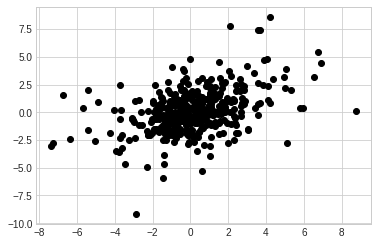

In [75]:
plt.style.use('seaborn-whitegrid')
x = [mu[0, 0, i, 2].item() for i in range(mu.size(2))]
y = [mu[0, 0, i, 3].item() for i in range(mu.size(2))]
plt.plot(x, y, 'o', color='black');


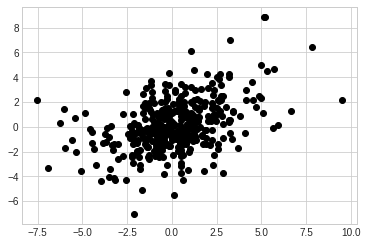

In [32]:
plt.style.use('seaborn-whitegrid')
x = [mu[0, 0, i, 2].item() for i in range(mu.size(2))]
y = [mu[0, 0, i, 3].item() for i in range(mu.size(2))]
plt.plot(x, y, 'o', color='black');

In [64]:
sigma_square = (R * (votes - mu) ** 2).sum(1) / sum_R

print (sigma_square.shape)

torch.Size([32, 400, 16])


**E-step (not last time)**

Then we call **E-step** to recompute the assignment probabilities **$r_{ij}$** based on the new Gaussian model and the new **$a_{j}$**.

In [65]:
mu, sigma_square, V_, a__ = mu.data, sigma_square.data, votes.data, activation.data

In [66]:
normal = Normal(mu, sigma_square[:, None, :, :] ** (1 / 2))

In [67]:
p = torch.exp(normal.log_prob(V_))

In [68]:
ap = a__ * p.sum(-1)

In [69]:
R = Variable(ap / torch.sum(ap, -1)[..., None], requires_grad=False)

**Last time**

In [40]:
const = (beta_v.expand_as(sigma_square) + torch.log(sigma_square)) * sum_R

In [41]:
a = torch.sigmoid(lambda_ * (beta_a.repeat(b, 1) - const.sum(2)))
print (a.shape)

torch.Size([32, 400])


### END Iteration

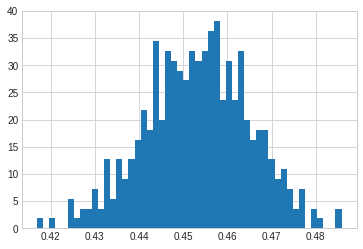

In [42]:
h = [a[0, i].item() for i in range(a.size(1))]
fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed
pl.hist(h,density=True,bins=50)      #use this to draw histogram of your data
pl.show()                   #use may also need add this 

torch.Size([32, 72, 400])


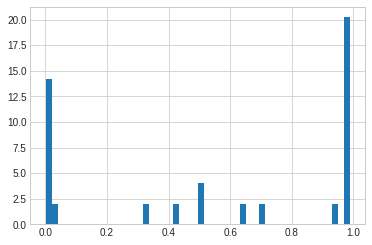

In [43]:
print (activation.shape)
h = [activation[0, 0, i].item() for i in range(activation.size(2))]
fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed
pl.hist(h,density=True,bins=50)      #use this to draw histogram of your data
pl.show()                   #use may also need add this 